In [ ]:
%tensorflow_version 1.x

In [ ]:
from google.colab import files
upload = files.upload()

Saving airbnb.csv to airbnb.csv


In [ ]:
import tensorflow_core as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import sklearn.model_selection as skm

import sys

np.set_printoptions(threshold=sys.maxsize)

In [ ]:
air_bnb = pd.read_csv("airbnb.csv")

dataset = air_bnb[["latitude", "longitude", "id"]].to_numpy()

scaler = skp.StandardScaler()
scaler.fit(dataset)

dataset = scaler.transform(dataset)

In [ ]:
air_bnb.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


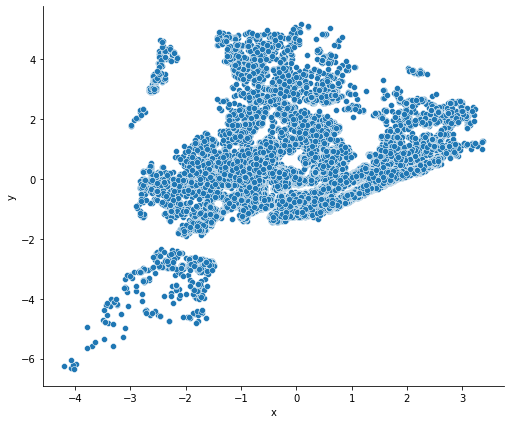

In [ ]:
df = pd.DataFrame(dataset[:, 0:2], columns=["x", "y"])
sb.relplot(x="x", y="y", data=df, kind="scatter", height=6, aspect=1.2)

In [ ]:
training_epochs = 50

neurons_diff_stop_cond = 0.0001

# 30 (6 * 5) neurons
width = 6
height = 5
num_neurons = width * height

# init sigma value = max(width, height) / 2
init_sigma = 3.0

learning_rate = 0.95

# dimension, depend on number of features
dim = 2

In [ ]:
x = tf.placeholder(tf.float32, [dim])
iter = tf.placeholder(tf.float32)

# (w x h) neurons, contains weight
neurons = tf.Variable(tf.random_normal([width * height, dim]))

In [ ]:
locs = [[x, y] for y in range(height) for x in range(width)]
# neurons locations
neu_locs = tf.cast(tf.convert_to_tensor(locs), tf.float32)

In [ ]:
expanded_x = tf.expand_dims(x, 0)

mse_to_neurons_by_weight = tf.reduce_mean(
    tf.square(tf.subtract(expanded_x, neurons)), 1
)

min_mse_idx = tf.argmin(mse_to_neurons_by_weight, 0)

bmu_loc = tf.cast(tf.stack(
    [tf.floormod(min_mse_idx, width), tf.floordiv(min_mse_idx, width)]
), tf.float32)

In [ ]:
# decay_rate = tf.exp(tf.divide(tf.multiply(-1.0, iter), training_epochs)) this type of decay produce too little learning rate
decay_rate = tf.subtract(1.0, tf.divide(iter, training_epochs))

alpha = tf.multiply(decay_rate, learning_rate)
sigma = tf.multiply(decay_rate, init_sigma)

expanded_bum_loc = tf.expand_dims(bmu_loc, 0)
mse_to_neurons_by_lateral = tf.reduce_mean(
    tf.square(tf.subtract(expanded_bum_loc, neu_locs)), 1
)

neighbor_factor = tf.exp(
    tf.divide(
        tf.multiply(-1.0, mse_to_neurons_by_lateral),\
        tf.multiply(2.0, tf.square(sigma))
    )
)

learning_factor = tf.multiply(alpha, neighbor_factor)

i = tf.constant(0)
m0 = tf.constant([[-99.0] * dim])  # dummy

c = lambda i, m: tf.less(i, num_neurons)
b = lambda i, m: [
    tf.add(i, 1),
    tf.concat(
        [m, tf.expand_dims(tf.tile(tf.slice(learning_factor, [i], [1]), [dim]), 0)], 0
    ),
]
tile = tf.while_loop(
    c,
    b,
    loop_vars=[i, m0],
    shape_invariants=[i.get_shape(), tf.TensorShape([None, dim])],
)

learning_factor_grid = tf.slice(tile[1], [1, 0], [num_neurons, dim])  # remove dummy

# vector from neurons to x = x - neurons
distance_vectors = tf.subtract(tf.expand_dims(x, 0), neurons)

neurons_diff = tf.multiply(learning_factor_grid, distance_vectors)

update_neurons = tf.assign(neurons, tf.add(neurons, neurons_diff))

In [ ]:
sess = tf.Session()
init = (tf.global_variables_initializer())
sess.run(init)

variance = np.float32(-1.)
for i in range(training_epochs):
    _variance = np.float32(0.)
    for data in dataset:
        _, diff = sess.run([update_neurons, neurons_diff], \
                    feed_dict={x: data[0:2], iter: i})
        
        _variance += np.sum(
            np.mean(np.absolute(diff), axis=1))

    _variance = _variance / dataset.shape[0] 
    
    if variance == -1.: variance = _variance
    elif np.absolute(variance - _variance) <= neurons_diff_stop_cond:
            break
    else: variance = _variance
    
    print(variance)
    if variance <= neurons_diff_stop_cond:
        break

17.585379384395132
16.876723080069535
16.179251457204213
15.488295071070661
14.817095306268534
14.159878310665713
13.512140811943961
12.874835105839043
12.246976940382453
11.631740208610287
11.032757695060845
10.44317287043665
9.866111054300031
9.30368838838327
8.749416479190101
8.20863329583802
7.678499846610083
7.16245014827692
6.669741921464363
6.188286762450148
5.719058697208303
5.261236450557317
4.830451094181409
4.409777328970242
4.00391527763575
3.6261836588608243
3.256595766438286
2.9112604177318744
2.583796751968504
2.2782528249309744
1.995611929900808
1.725142365016873
1.4848877377543717
1.259352390965334
1.0579254652827488
0.8748197668473259
0.711338311049187
0.568450610044483
0.44614815548624603
0.34131980839042847
0.25309062707715513
0.18092316762961447
0.12272233948384292
0.07746680146870846
0.0448930295067875
0.023466330513728397
0.012298946612719219
0.007897580348954072
0.005260746132097479
0.0026308080952327693


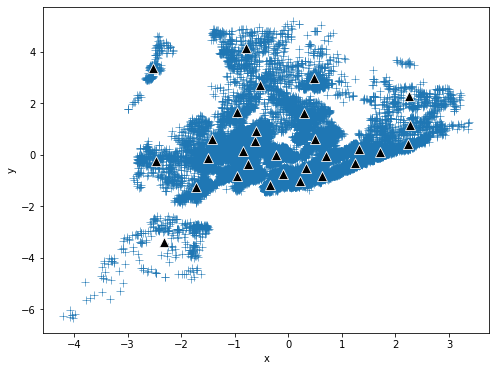

In [ ]:
centroids = sess.run(neurons)

colors = sb.color_palette("Paired", 10)

fig = plt.gcf()
fig.set_size_inches(8, 6)

df = pd.DataFrame(dataset[:, 0:2], columns=["x", "y"])
sb.scatterplot(data=df, x="x", y="y",\
            marker="+", s=50)

df_centr = pd.DataFrame(centroids,\
            columns=["x", "y"])
sb.scatterplot(data=df_centr, x="x", y="y",\
    marker="^", color="#000", s=100)

plt.show()